In [54]:
import numpy as np
from scipy.stats import entropy
from scipy.special import rel_entr
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# Define a small value epsilon
epsilon = 1e-10
# Define the client distributions with all labels filled
client_distributions = [
    {0: 325, 1: 677, 2: 36, 3: 4, 4: 159, 5: 235, 6: 4, 7: 131, 8: 1771, 9: 1078},
    {0: 2530, 1: 2598, 2: 555, 3: 313, 4: 8, 5: epsilon, 6: epsilon, 7: epsilon, 8: epsilon, 9: epsilon},
    {0: 1453, 1: 438, 2: 1064, 3: 124, 4: 226, 5: 342, 6: 542, 7: 1660, 8: 250, 9: epsilon},
    {0: 20, 1: 97, 2: 122, 3: 837, 4: 222, 5: 2400, 6: 1288, 7: 94, 8: 972, 9: epsilon},
    {0: 631, 1: 109, 2: 2243, 3: 1286, 4: 3128, 5: epsilon, 6: epsilon, 7: epsilon, 8: epsilon, 9: epsilon},
    {0: 204, 1: 883, 2: 18, 3: 1634, 4: 103, 5: 1, 6: 177, 7: 162, 8: 553, 9: 7},
    {0: 244, 1: 1510, 2: 1007, 3: 122, 4: 942, 5: 776, 6: 2030, 7: epsilon, 8: epsilon, 9: epsilon},
    {0: 30, 1: 76, 2: 30, 3: 45, 4: 248, 5: 24, 6: 678, 7: 3988, 8: 520, 9: 3836},
    {0: 53, 1: 53, 2: 714, 3: 583, 4: 359, 5: 1172, 6: 1045, 7: 71, 8: 801, 9: 223},
    {0: 433, 1: 301, 2: 169, 3: 1183, 4: 447, 5: 471, 6: 154, 7: 159, 8: 984, 9: 805}
]



In [42]:


# Calculate the total samples across all clients
total_samples = sum([sum(dist.values()) for dist in client_distributions])

# Calculate the overall label distribution
overall_distribution = {label: sum(dist.get(label, 0) for dist in client_distributions) for label in set().union(*client_distributions)}
overall_distribution = {k: v / total_samples for k, v in overall_distribution.items()}




In [44]:
# Calculate the Kullback-Leibler (KL) divergence between each client's distribution and the overall distribution
kl_divergences = []
for client_dist in client_distributions:
    client_dist_normalized = {k: v / sum(client_dist.values()) for k, v in client_dist.items()}
    kl_divergence = entropy(list(client_dist_normalized.values()), list(overall_distribution.values()))
    kl_divergences.append(kl_divergence)

# Print the results
print(f"Overall label distribution: {overall_distribution}")
print(f"KL divergences for each client: {kl_divergences}")

Overall label distribution: {0: 0.0987166666666642, 1: 0.11236666666666385, 2: 0.09929999999999752, 3: 0.10218333333333078, 4: 0.09736666666666423, 5: 0.09035000000000108, 6: 0.09863333333333421, 7: 0.10441666666666906, 8: 0.09751666666666924, 9: 0.09915000000000586}
KL divergences for each client: [0.6812982616228349, 1.147560259129296, 0.3966420840352277, 0.7322510241864811, 1.0095435433098623, 0.7071554139337316, 0.5881863183271736, 1.0008187178490515, 0.3722677705906084, 0.2259769523632737]


In [45]:
# Normalize the distributions
def normalize_distribution(dist):
    total = sum(dist.values())
    return {k: v / total for k, v in dist.items()}

normalized_distributions = [normalize_distribution(d) for d in client_distributions]

# Convert dictionaries to arrays for KL divergence calculation
def dict_to_array(d):
    return np.array([d[k] for k in sorted(d.keys())])

array_distributions = [dict_to_array(d) for d in normalized_distributions]

# Compute KL divergence
def kl_divergence(p, q):
    return np.sum(rel_entr(p, q))

kl_matrix = np.zeros((len(array_distributions), len(array_distributions)))

for i in range(len(array_distributions)):
    for j in range(len(array_distributions)):
        if i != j:
            kl_matrix[i][j] = kl_divergence(array_distributions[i], array_distributions[j])

# Display the KL divergence matrix
kl_df = pd.DataFrame(kl_matrix, index=[f"Client {i}" for i in range(1, len(array_distributions)+1)], columns=[f"Client {i}" for i in range(1, len(array_distributions)+1)])
print(kl_df)

           Client 1   Client 2   Client 3   Client 4   Client 5  Client 6  \
Client 1   0.000000  21.935877   8.238907   8.230392  22.504985  1.818240   
Client 2   1.616550   0.000000   1.003399   3.554568   1.955287  1.282529   
Client 3   1.745304  13.622191   0.000000   2.000843  13.895861  1.644677   
Client 4   2.470172  24.024111   1.319565   0.000000  23.845645  3.041441   
Client 5   3.031223   2.819339   1.459344   2.171707   0.000000  2.249004   
Client 6   2.819544   7.796402   1.640407   1.281284   8.040997  0.000000   
Client 7   2.634896  13.295505   0.826823   1.123374  13.191376  1.960036   
Client 8   1.480818  29.204510  12.600906  13.684204  29.275633  3.055000   
Client 9   2.181176  19.909891   2.090843   1.427738  19.384977  2.336850   
Client 10  1.313118  15.369760   5.441961   5.139243  14.986964  1.239480   

            Client 7  Client 8  Client 9  Client 10  
Client 1   20.509014  1.452844  1.233271   0.453083  
Client 2    1.307365  4.219468  3.084069   1

In [47]:
# Create a graph and add edges with weights
G = nx.Graph()
for i in range(len(array_distributions)):
    for j in range(i + 1, len(array_distributions)):
        G.add_edge(f"Client {i+1}", f"Client {j+1}", weight=kl_matrix[i][j])

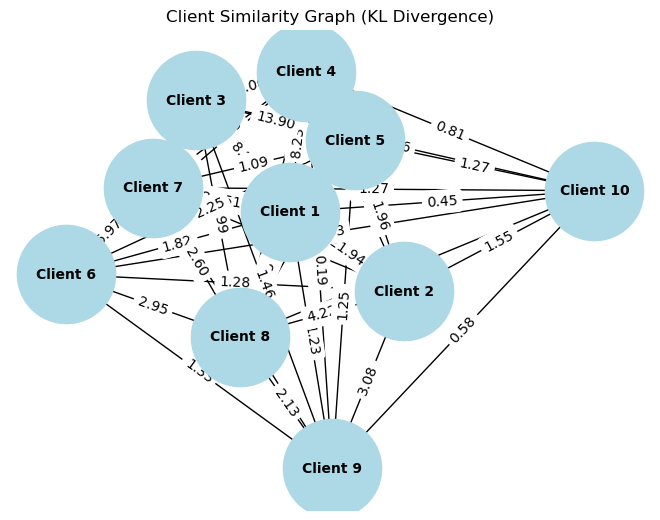

In [50]:
# Draw the graph
pos = nx.spring_layout(G)  # positions for all nodes
weights = nx.get_edge_attributes(G, 'weight')
nx.draw(G, pos, with_labels=True, node_size=5000, node_color='lightblue', font_size=10, font_color='black', font_weight='bold')
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f"{w:.2f}" for u, v, w in G.edges(data='weight')})
plt.title("Client Similarity Graph (KL Divergence)")
plt.show()

In [52]:

# Compute the Minimum Spanning Tree (MST)
mst = nx.minimum_spanning_tree(G)

# Calculate centrality measures on the MST
degree_centrality = nx.degree_centrality(mst)
betweenness_centrality = nx.betweenness_centrality(mst, weight='weight')
closeness_centrality = nx.closeness_centrality(mst, distance='weight')

# Create a dataframe to display the centrality measures
centrality_df = pd.DataFrame({
    'Degree Centrality': degree_centrality,
    'Betweenness Centrality': betweenness_centrality,
    'Closeness Centrality': closeness_centrality
})

Degree Centrality (sorted):
Client 10    0.555556
Client 9     0.333333
Client 3     0.222222
Client 7     0.222222
Client 1     0.111111
Client 2     0.111111
Client 4     0.111111
Client 5     0.111111
Client 6     0.111111
Client 8     0.111111
Name: Degree Centrality, dtype: float64

Betweenness Centrality (sorted):
Client 10    0.805556
Client 9     0.555556
Client 3     0.222222
Client 7     0.222222
Client 1     0.000000
Client 2     0.000000
Client 4     0.000000
Client 5     0.000000
Client 6     0.000000
Client 8     0.000000
Name: Betweenness Centrality, dtype: float64

Closeness Centrality (sorted):
Client 10    0.832411
Client 9     0.752145
Client 4     0.666917
Client 1     0.623414
Client 6     0.599429
Client 7     0.524269
Client 3     0.523443
Client 8     0.412213
Client 2     0.356845
Client 5     0.347365
Name: Closeness Centrality, dtype: float64


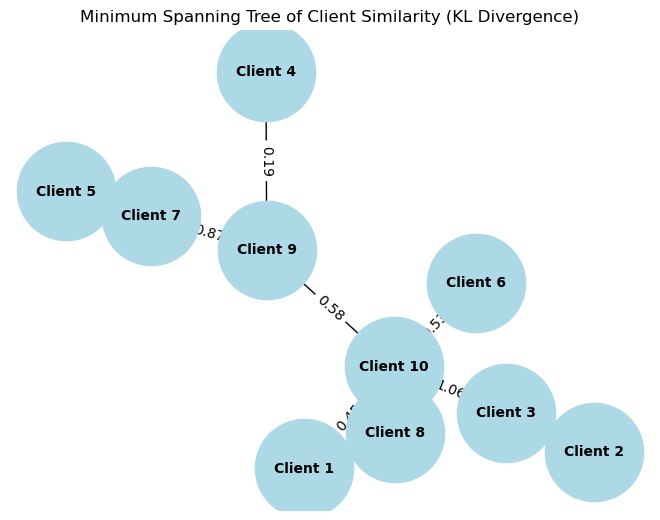

In [53]:
# Sort and print centrality measures
sorted_degree_centrality = centrality_df['Degree Centrality'].sort_values(ascending=False)
sorted_betweenness_centrality = centrality_df['Betweenness Centrality'].sort_values(ascending=False)
sorted_closeness_centrality = centrality_df['Closeness Centrality'].sort_values(ascending=False)

print("Degree Centrality (sorted):")
print(sorted_degree_centrality)
print("\nBetweenness Centrality (sorted):")
print(sorted_betweenness_centrality)
print("\nCloseness Centrality (sorted):")
print(sorted_closeness_centrality)

# Draw the MST
pos = nx.spring_layout(mst)  # positions for all nodes
weights = nx.get_edge_attributes(mst, 'weight')
nx.draw(mst, pos, with_labels=True, node_size=5000, node_color='lightblue', font_size=10, font_color='black', font_weight='bold')
nx.draw_networkx_edge_labels(mst, pos, edge_labels={(u, v): f"{w:.2f}" for u, v, w in mst.edges(data='weight')})
plt.title("Minimum Spanning Tree of Client Similarity (KL Divergence)")
plt.show()


Clustered Clients using DBSCAN with KL Divergence:
      Client  Cluster
0   Client 1        0
1   Client 2       -1
2   Client 3        3
3   Client 4        1
4   Client 5       -1
5   Client 6        2
6   Client 7        3
7   Client 8       -1
8   Client 9        0
9  Client 10        0


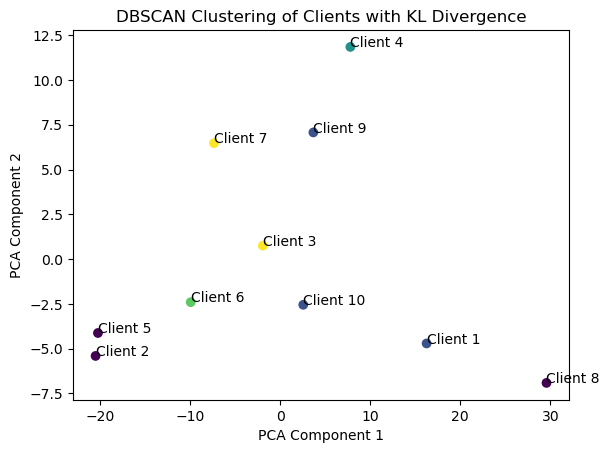

In [56]:
# Perform DBSCAN clustering with the precomputed KL divergence matrix
dbscan = DBSCAN(eps=1.0, min_samples=2, metric='precomputed')
clusters = dbscan.fit_predict(kl_matrix)
num_clients = 10
# Create a dataframe to display the client clusters
clustered_clients = pd.DataFrame({'Client': [f"Client {i+1}" for i in range(num_clients)], 'Cluster': clusters})
print("\nClustered Clients using DBSCAN with KL Divergence:")
print(clustered_clients)

# Draw a 2D representation using PCA for visualization
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(kl_matrix)
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis')
for i, client in enumerate(clustered_clients['Client']):
    plt.annotate(client, (reduced_features[i, 0], reduced_features[i, 1]))
plt.title("DBSCAN Clustering of Clients with KL Divergence")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()








In [58]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Compute the silhouette score
silhouette_avg = silhouette_score(kl_matrix, clusters, metric='precomputed')
print(f"\nSilhouette Score: {silhouette_avg}")

# Compute the Davies-Bouldin index
db_index = davies_bouldin_score(kl_matrix, clusters)
print(f"Davies-Bouldin Index: {db_index}")


Silhouette Score: -0.1927480250025618
Davies-Bouldin Index: 2.3929489929021828
